# Example in Ecuador: Working with OpenEO on Copernicus Data for Vegetation Indexes and Burn Scar analysis

Now that we have explored the basics of the Copernicus Data Space ecosystem and openEO, it’s time to apply these tools to a real-world case. In this exercise, we will use Sentinel-2 satellite data to investigate the effects of the severe drought and widespread fires that affected Ecuador in 2024.

We will begin by calculating NDVI and NDWI to assess vegetation health and moisture conditions before the fires. Later, we will create a burn scar index to map fire-affected areas and compare the pre- and post-event landscapes.

## 1.1 Installing the needed software
To configure our software environment, we need to install several Python libraries which enable us to use openEO and some functions for analyzing and visualizing the satellite data:
- `openeo`: To access Earth Observation data via the Copernicus Data Space Ecosystem.
- `numpy`: For numerical data processing.
- `matplotlib`: For visualization.
- `rasterio`: To read and process geospatial TIFF files.
- `os`: For interacting with the file system.

If you're interested to learn more about the openeo python library, you can find the detailed documentation here: https://openeo.org/documentation/1.0/python/.

You can install these libraries using the following command if any of imports should fail:
```bash
!pip install openeo numpy matplotlib rasterio

In [68]:
!pip install geopandas shapely

In [10]:
!pip install geopandas shapely
import openeo
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage import exposure
import os
import geopandas as gpd
import zipfile
import glob


Unzip and load the shape file from the Inputs folder. 

Found shapefiles: ['Inputs/AreaQuilanga2024/AreaQuilanga2024/AreaQuilanga2024.shp', 'Inputs/AreaQuilanga2024/QuilangaArea/AreaQuilanga2024.shp']


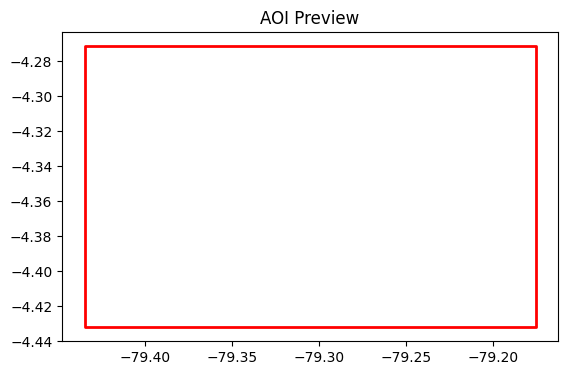

In [24]:
zip_path = "Inputs/AreaQuilanga2024.zip"
extract_dir = "Inputs/AreaQuilanga2024"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Search for .shp recursively in subfolders
shp_files = glob.glob(os.path.join(extract_dir, "**", "*.shp"), recursive=True)
print("Found shapefiles:", shp_files)

if not shp_files:
    raise FileNotFoundError("No .shp file found in the extracted zip.")

shp_path = shp_files[0]

# Load shapefile
aoi = gpd.read_file(shp_path).to_crs(epsg=4326)

aoi.plot(edgecolor='red', facecolor='none', linewidth=2)
plt.title("AOI Preview")
plt.show()


## 3.3.2 Sign in with your Account

To begin with, we need to connect to the Copernicus Data Space Ecosystem and authenticate ourselfes as a registered user. This enables us to get access to the data and services of the CDSE platform’s data and services. 

**Before you continue with the notebook, make sure that you have successfully registered as a user of the Copernicus Data Space Ecosystem at https://dataspace.copernicus.eu/**


In [29]:
# to authenticate, we use the following function provided by the openeo library:

connection = openeo.connect(url="openeo.dataspace.copernicus.eu")
connection.authenticate_oidc()

# after activating this cell, a link to CDSE's authentication widget will be displayed
# follow the link and confirm that this notebook can access the CDSE with your credentials
# after successfully completing this step a green checkmark followed by "Authorized successfully" shoukd appear

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

## 3.3.3 Creating filters for retrieving the Sentinel 2 data

Next, we want to retrieve usable Sentinel-2 data for the area around Loja in Ecuador, where the fire event occurred during the year 2024.

To focus our search on the region of Loja, we use a bounding box as a **spatial filter**. We define the coordinates of the bounding box of our area of interest in such a way that the region around Loja is enclosed.  


As for the **temporal filter** we will focus on the period shortly before the flood, from the 01.07.2024 to the 22.08.2024. 
Since we do not know exactly when a usable image was taken for our target area at that time, we specify a time period that includes the last few days before the weather event.


In [31]:
# time period before the fire event

period_before = ["2024-07-01", "2024-08-22"] 


## 3.3.4 Loading Sentinel 2 data with a Datacube

To calculate the NDVI (Normalized Difference Vegetation Index), we load the bands B08 (NIR) and B04 (Red) of the Sentinel-2 data as a datacube. Datacubes are a key concept in OpenEO. If you want to learn more about datacubes, follow this link: https://openeo.org/documentation/1.0/datacubes.html. 
We will also add a maximum cloud cover to filter for suitable images.


In [56]:
import json
aoi_geojson = json.loads(aoi.to_json())
aoi_feature = aoi_geojson["features"][0]["geometry"]

# Now use in load_collection
s2_data_before = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=aoi_feature,
    temporal_extent=period_before,
    bands=["B04", "B08","B11", "B12"],
    max_cloud_cover=20
)


## 3.3.5 Calculating the NDVI
For this analysis, we will use the B04 (red) and B08 (near-infrared) bands of Sentinel-2, which are essential for NDVI calculations. This is a common index used to measure vegetation health. 
Luckily for us there already exists a function for that from the OpenEO API. OpenEO has many predefined functions like this, called processes, to perform calculations or manipulate your data. These processes are also documented and can be found here: https://openeo.org/documentation/1.0/processes.html.

The NDVI formula is: NDVI = (NIR - Red) / (NIR + Red)

This index helps us to get a first impression of the impact of the fire on the vegetation. We will first create the NDVI image for the time before the fire and then compare it with the situation after the fire.

In [57]:
ndvi_before = s2_data_before.ndvi(nir="B08", red="B04")

## 3.3.6 Saving the NDVI Result as a GeoTIFF
In this step, we calculate the mean NDVI over time for the pre-fire data. This reduces the temporal dimension and allows us to generate a single NDVI image representing the average vegetation health before the fire.

We save the resulting NDVI image in GeoTIFF format. The GeoTIFF format allows us to store geospatial raster data with the correct geographic coordinates, ensuring that it can be easily loaded into GIS software for further analysis.

In [58]:
ndvi_mean_before = ndvi_before.reduce_dimension(dimension="t", reducer="mean")

result_before = ndvi_mean_before.save_result(format="GTiff")

## 3.3.7 Creating and Starting a Batch Job
Since the processing of satellite data can take some time, we use OpenEO's batch job feature. A batch job processes the data asynchronously on the OpenEO backend, and once completed, we can download the results.

Here, we create and start a batch job to process the pre-fire NDVI data. Once the job is finished, the resulting NDVI image is downloaded and saved as a GeoTIFF file.

As the batch job processes, it’s important to monitor the job’s progress. This ensures that we know when the processing is complete and can download the results.

Once the job is finished (status = "finished"), the results can be downloaded directly, as shown in the previous step. If the job is still running or encounters an error, appropriate action can be taken.

In [59]:
output_dir = "results" 
sampleOutput_dir = "sampleOutput"

In [61]:
job_before = result_before.create_job()
job_before.start_and_wait()
if job_before.status() == "finished":
    job_before.get_results().download_files(output_dir)
    print("NDVI before fire downloaded successfully.")
else:
    print("Error in downloading NDVI before fire!")

downloaded_files = os.listdir(output_dir)
for filename in downloaded_files:
    if filename == "openEO.tif":
        file_path = os.path.join(output_dir, filename)
        print(f"Renaming {filename} to NDVI_Before_Fire.tif")
        os.rename(file_path, os.path.join(output_dir, "NDVI_Before_Fire.tif"))

0:00:00 Job 'j-250814115749475b891f0ce4540c8400': send 'start'
0:00:17 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:00:22 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:00:29 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:00:37 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:00:47 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:00:59 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:01:14 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:01:34 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:01:58 Job 'j-250814115749475b891f0ce4540c8400': running (progress N/A)
0:02:28 Job 'j-250814115749475b891f0ce4540c8400': finished (progress 100%)
NDVI before fire downloaded successfully.
Renaming openEO.tif to NDVI_Before_Fire.tif


## 3.3.8 Show resulting .tif file
After downloading and renaming the GeoTIFF file, we can visualize the pre-fire NDVI image. By using rasterio and matplotlib, we can load and display the NDVI data with a suitable color map to interpret vegetation health. 
This visualization helps us to understand the state of the vegetation before the fire and serves as a baseline for later comparison with post-fire data.

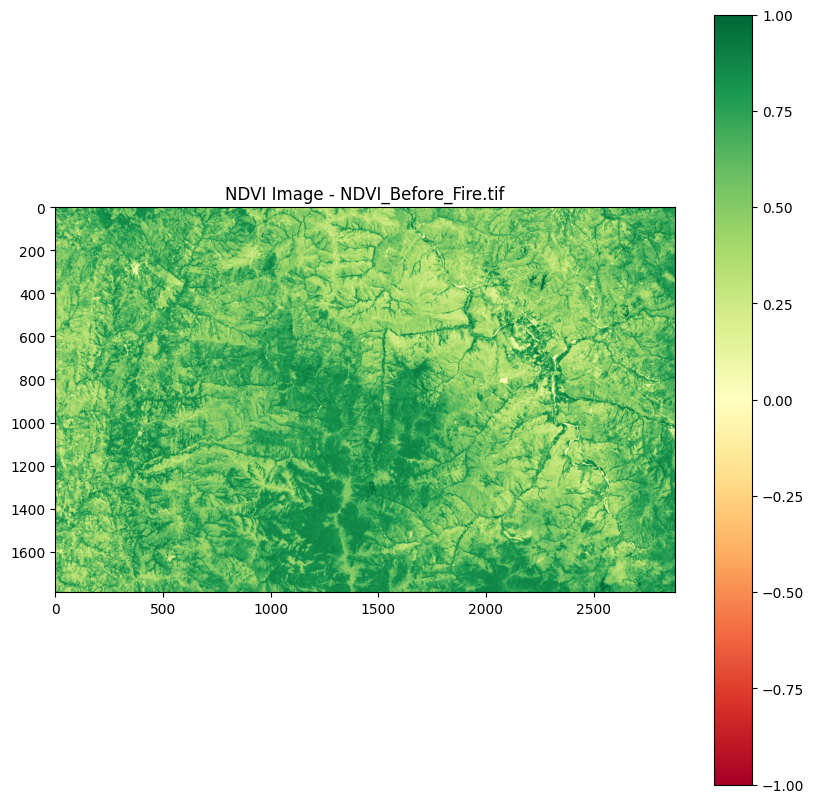

In [62]:
def plot_ndvi(filename, output_dir):
    file_path = os.path.join(output_dir, filename)
    
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            ndvi_data = src.read(1)
            ndvi_data = np.clip(ndvi_data, -1, 1)
            
            plt.figure(figsize=(10, 10))
            plt.title(f'NDVI Image - {filename}')
            plt.imshow(ndvi_data, cmap='RdYlGn', vmin=-1, vmax=1)
            plt.colorbar()
            plt.show()
    else:
        print(f"File {filename} not found!")

plot_ndvi("NDVI_Before_Fire.tif", output_dir)

## 3.3.9 Your Turn
Now that you have seen the workflow try recreating it. Therefor fill the gaps in the following code snippet and run them after that. 

We want to get a second .tif file for our area of interest that shows the situation after the fire. Therefor we want to look for Sentinel-2 data within a time period after the fire, i.e. for example between the 27.08.2024 and 01.10.2024. 

Compare the results with the pre-fire NDVI to observe the impact of the fire on the vegetation. 

Once you've generated the post-fire NDVI image, we compute the NDVI difference to assess the changes in vegetation and identify areas that were most affected by the fire.

In [64]:
# creating the time filter for the period shortly after the rainfall event 
period_after = ["2024-08-27", "2024-10-01"]                 # Please insert a time period here.

s2_data_after = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent=aoi_feature,
    temporal_extent=period_after,
    bands=["B04", "B08","B11", "B12"],
    max_cloud_cover=20
)

# calculation of NDVI
ndvi_after = s2_data_after.ndvi(nir="B08", red="B04")

# use a reducer if necessary
ndvi_mean_after = ndvi_after.reduce_dimension(dimension="t", reducer="mean")

# Saving the NDVI result as a .tif file
result_after = ndvi_mean_after.save_result(format="GTiff")

# creating and starting the job
job_after = result_after.create_job()
job_after.start_and_wait()
if job_after.status() == "finished":
    job_after.get_results().download_files(output_dir)
    print("NDVI after fire downloaded successfully.")
else:
    print("Error in downloading NDVI after fire!")

# Renaming file
downloaded_files = os.listdir(output_dir)
for filename in downloaded_files:
    if filename == "openEO.tif":
        file_path = os.path.join(output_dir, filename)
        print(f"Renaming {filename} to NDVI_After_Fire.tif")
        os.rename(file_path, os.path.join(output_dir, "NDVI_After_Fire.tif"))

0:00:00 Job 'j-250814120739489b8641af05dbc0249e': send 'start'
0:00:13 Job 'j-250814120739489b8641af05dbc0249e': created (progress 0%)
0:00:19 Job 'j-250814120739489b8641af05dbc0249e': created (progress 0%)
0:00:25 Job 'j-250814120739489b8641af05dbc0249e': created (progress 0%)
0:00:33 Job 'j-250814120739489b8641af05dbc0249e': running (progress N/A)
0:00:43 Job 'j-250814120739489b8641af05dbc0249e': running (progress N/A)
0:00:56 Job 'j-250814120739489b8641af05dbc0249e': running (progress N/A)
0:01:12 Job 'j-250814120739489b8641af05dbc0249e': running (progress N/A)
0:01:31 Job 'j-250814120739489b8641af05dbc0249e': running (progress N/A)
0:01:55 Job 'j-250814120739489b8641af05dbc0249e': running (progress N/A)
0:02:25 Job 'j-250814120739489b8641af05dbc0249e': running (progress N/A)
0:03:02 Job 'j-250814120739489b8641af05dbc0249e': finished (progress 100%)
NDVI after fire downloaded successfully.
Renaming openEO.tif to NDVI_After_Fire.tif


## 3.3.10 Comparing pre- and post-flood situation
Now you can display both NDVI images side by side and compare the situation in Loja before and after the fire event. 

In [ ]:
# definition of the NDVI-files that shall be plotted
files = [
    ("NDVI_Before_Fire.tif", output_dir, "Before Fire"),
    ("NDVI_After_Fire.tif", output_dir, "After Fire (your result)")]



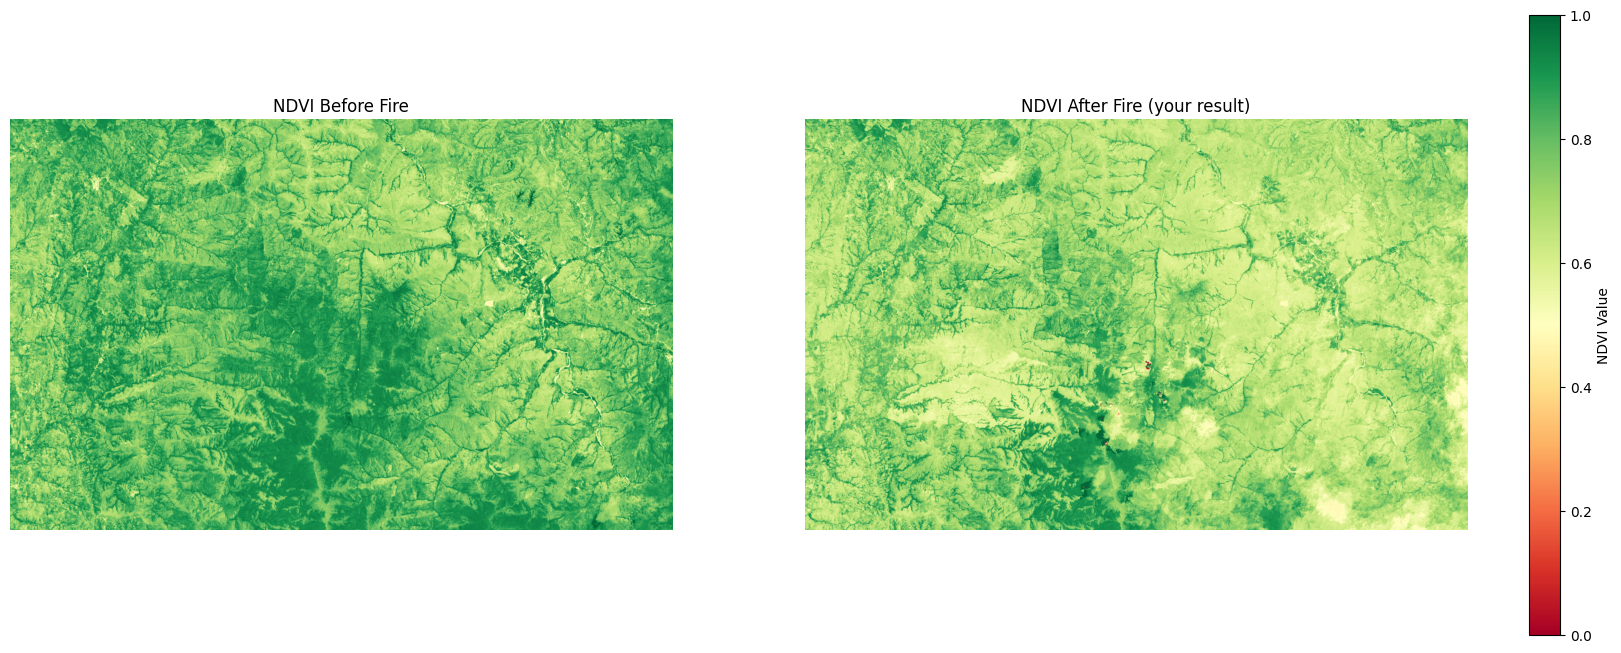

In [66]:

def plot_ndvi_images(files_and_dirs):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    for ax, (filename, directory, title) in zip(axes, files_and_dirs):
        file_path = os.path.join(directory, filename)
        
        if os.path.exists(file_path):
            with rasterio.open(file_path) as src:
                data = src.read(1)
                data = np.clip(data, -1, 1)

            ax.imshow(data, cmap='RdYlGn', vmin=-1, vmax=1)
            ax.set_title(f'NDVI {title}')
            ax.axis('off')
        else:
            print(f"File {filename} not found in directory {directory}.")

    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap='RdYlGn'), ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('NDVI Value')

    plt.show()

plot_ndvi_images(files)

## 3.3.11 Comparing pre- and post-fire situation using the NDVI difference

After calculating the NDVI values for both pre-fire and post-fire data, we will visualize the NDVI difference to understand how the fire impacted vegetation in the Loja region.

The color scale:
- **Green**: Indicates areas where vegetation has even improved.
- **Red**: Indicates areas where vegetation health has decreased, possibly due to burning.

Below is an example plot showing the NDVI difference:
```python
plt.imshow(ndvi_difference, cmap="RdYlGn")
plt.colorbar(label="NDVI Difference")
plt.title("NDVI Difference (After - Before)")
plt.show()

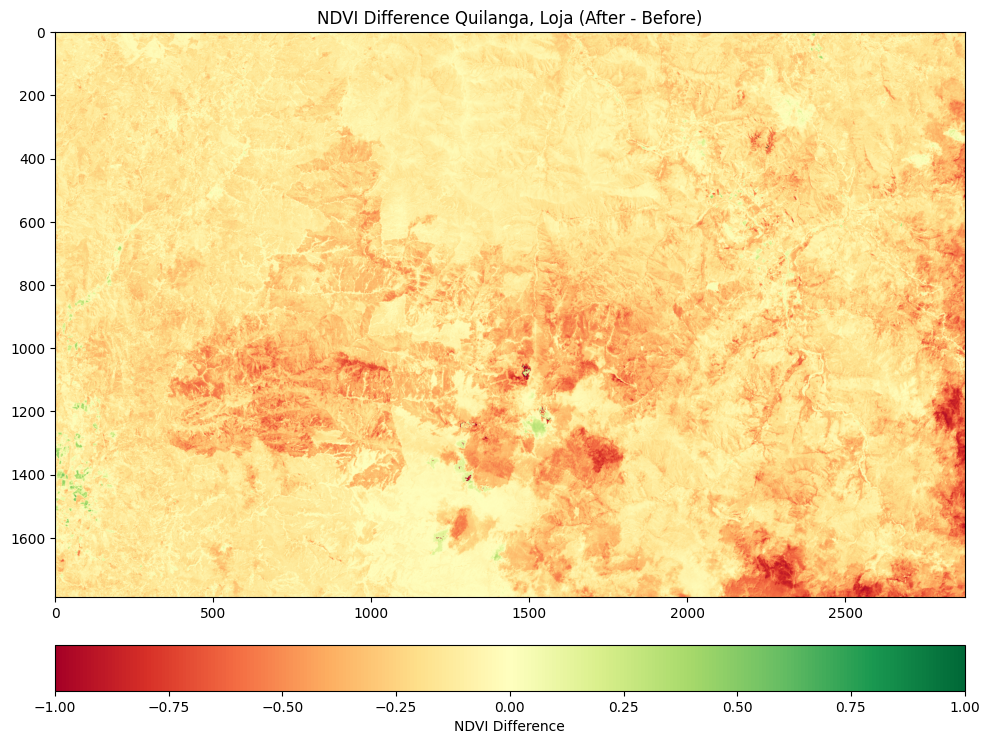

In [71]:
def calculate_ndvi_difference(before_path, after_path):
    with rasterio.open(before_path) as before_src:
        ndvi_before = before_src.read(1)
    
    with rasterio.open(after_path) as after_src:
        ndvi_after = after_src.read(1)

    ndvi_before = np.clip(ndvi_before, -1, 1)
    ndvi_after = np.clip(ndvi_after, -1, 1)
    
    ndvi_diff = ndvi_after - ndvi_before
    
    plot_ndvi_difference(ndvi_diff)

def plot_ndvi_difference(ndvi_diff):
    plt.figure(figsize=(10, 10))
    plt.title('NDVI Difference Quilanga, Loja (After - Before)')
    img = plt.imshow(ndvi_diff, cmap='RdYlGn', vmin=-1, vmax=1)
    cbar = plt.colorbar(img, orientation='horizontal', pad=0.05)
    cbar.set_label('NDVI Difference')
    plt.tight_layout()
    plt.show()

before_path = os.path.join(files[0][1], files[0][0])
after_path = os.path.join(files[1][1], files[1][0])

calculate_ndvi_difference(before_path, after_path)



## Congratulations!!!

You have mastered this exercise. You have seen how easily you can get to EO data and process it through the openEO API and Copernicus Data Space Ecosystem.

In this module, you learned how to retrieve and analyze Sentinel-2 data using NDVI to assess the impact of the fire in Loja, Ecuador. By comparing the pre- and post-fire vegetation health, you can now identify areas most affected by the disaster.

The use of OpenEO's batch processing and geospatial data handling in Python allows for efficient, large-scale environmental monitoring, which can be applied to many other natural disasters or environmental changes.

You are invited to play around with the code to better understand its details.